In [ ]:
import tensorflow
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt
import cv2
import os           
from tensorflow.keras.layers import BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
training_dir = pathlib.Path(r'/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Training')
testing_dir = pathlib.Path(r'/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Testing')

In [ ]:
print(list(training_dir.glob('0/*.jpg'))[:5])
print(list(testing_dir.glob('0/*.jpg'))[:5])

[PosixPath('/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Training/0/m3 (147).jpg'), PosixPath('/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Training/0/m2 (86).jpg'), PosixPath('/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Training/0/gg (762).jpg'), PosixPath('/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Training/0/m3 (162).jpg'), PosixPath('/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Training/0/m (169).jpg')]
[PosixPath('/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Testing/0/image(2).jpg'), PosixPath('/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Testing/0/image(12).jpg'), PosixPath('/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Testing/0/image(100).jpg'), PosixPath('/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Testing/0/image(14).jpg'), PosixPath('/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/Testing/0/image(17).jpg')]


In [ ]:
tr_genr = ImageDataGenerator(rescale = 1 / 255,
                              horizontal_flip=True,
                              fill_mode='nearest')
ts_genr = ImageDataGenerator(rescale = 1 / 255)

In [ ]:
training_generator = tr_genr.flow_from_directory(training_dir,
                                                 target_size = (128, 128), 
                                                class_mode = 'binary')
testing_generator = ts_genr.flow_from_directory(testing_dir,
                                                target_size = (128, 128),
                                                class_mode = 'binary')

Found 2871 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


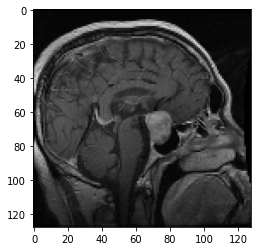

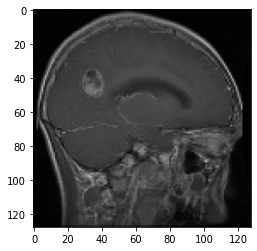

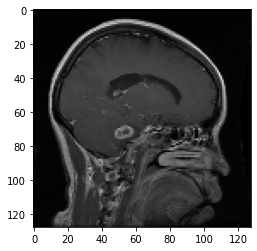

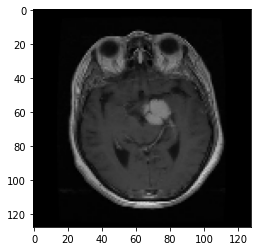

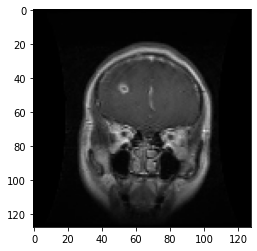

In [ ]:
x,y = training_generator.next()
for i in range(0,5):
     image = x[i]
     plt.imshow(image)
     plt.show()

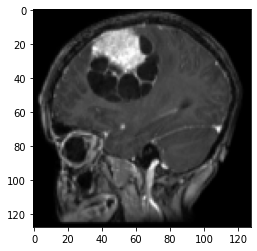

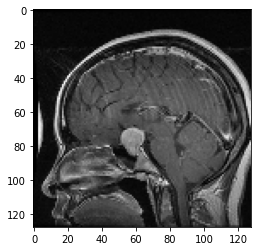

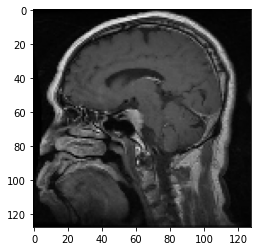

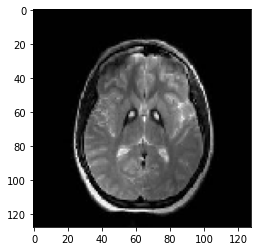

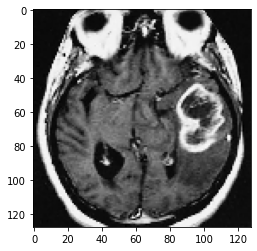

In [ ]:
x,y = testing_generator.next()
for i in range(0,5):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
local_pretrained_weight_file = "/content/drive/MyDrive/Face_Recognition/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
pretrained_model = InceptionV3(input_shape = (128, 128, 3), include_top = False, weights = None)

In [ ]:
pretrained_model.load_weights(local_pretrained_weight_file)

In [ ]:
for layer in pretrained_model.layers:
    layer.trainable = False

In [ ]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 63, 63, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 63, 63, 32)   0           batch_normalization_96[0][0]     
_______________________________________________________________________________________

In [ ]:
out_layer = pretrained_model.get_layer('mixed10')
output_layer = out_layer.output
output_layer

<KerasTensor: shape=(None, 2, 2, 2048) dtype=float32 (created by layer 'mixed10')>

In [ ]:
x = layers.Flatten()(output_layer)
x = BatchNormalization()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(28, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation = 'sigmoid')(x) #sigmoid

model = Model(pretrained_model.input, x)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs['val_accuracy']>0.93):
            print("\n Reached 93.0% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

history = model.fit(
      training_generator,
      epochs=300,
      callbacks = [callbacks],
      validation_data=testing_generator)


Epoch 1/300
90/90 [==============================] - 28s 244ms/step - loss: 0.5006 - accuracy: 0.8161 - val_loss: 0.5324 - val_accuracy: 0.7335
Epoch 2/300
90/90 [==============================] - 20s 225ms/step - loss: 0.3911 - accuracy: 0.8391 - val_loss: 0.5064 - val_accuracy: 0.7310
Epoch 3/300
90/90 [==============================] - 20s 223ms/step - loss: 0.3650 - accuracy: 0.8527 - val_loss: 0.4730 - val_accuracy: 0.7563
Epoch 4/300
90/90 [==============================] - 20s 220ms/step - loss: 0.2964 - accuracy: 0.8694 - val_loss: 0.4435 - val_accuracy: 0.7716
Epoch 5/300
90/90 [==============================] - 20s 218ms/step - loss: 0.2499 - accuracy: 0.8847 - val_loss: 0.4357 - val_accuracy: 0.7411
Epoch 6/300
90/90 [==============================] - 20s 221ms/step - loss: 0.1988 - accuracy: 0.9108 - val_loss: 0.4017 - val_accuracy: 0.7589
Epoch 7/300
90/90 [==============================] - 20s 220ms/step - loss: 0.1756 - accuracy: 0.9237 - val_loss: 0.4216 - val_accuracy:

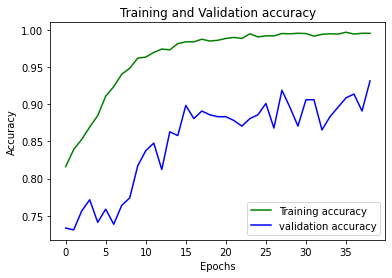

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

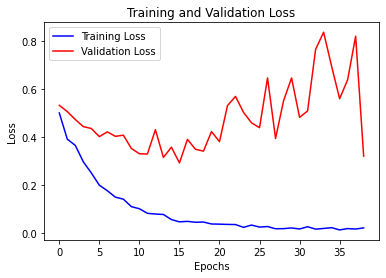

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
model.save('/content/drive/MyDrive/Dataset/Brain_Tumour_Detection/model.h5')